Scoring in next 10 actions model - Model Evaluation - GBM

In [1]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-vaep-model/src")

In [2]:
import pandas as pd
import numpy as np
import joblib

import warnings
warnings.filterwarnings('ignore')

from config import exp_vaep_chain_output_path, exp_vaep_modelling_file_path
from modelling_data_contract import ModellingDataContract
from visualization.model_evaluation import XGBRegressorEvaluator

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


New Model

In [3]:
model_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-vaep-model/models/models/exp_vaep_scores_v3.joblib"
data_file_path = exp_vaep_chain_output_path

Load Data

In [4]:
evaluation_data = pd.read_csv(data_file_path)
evaluation_data = evaluation_data[~evaluation_data['exp_vaep_value'].isnull()]

In [5]:
modelling_data = pd.read_csv(exp_vaep_modelling_file_path)
modelling_data = modelling_data[['match_id', 'chain_number', 'order', 'exp_scoresTrainingSet', 'exp_scoresTestSet', 'exp_scoresValidationSet', 'exp_concedesTrainingSet', 'exp_concedesTestSet', 'exp_concedesValidationSet']]
evaluation_data = evaluation_data.merge(modelling_data, how = "left", on = ['match_id', 'chain_number', 'order'])

In [35]:
evaluation_data = evaluation_data.replace({'True':True, 'False':False})

In [36]:
evaluation_data.head()

Chain_Number Initial_State Final_State  Order  Quarter  \
0             1  centreBounce        goal    2.0        1   
1             1  centreBounce        goal    3.0        1   
2             1  centreBounce        goal    4.0        1   
3             1  centreBounce        goal    5.0        1   
4             1  centreBounce        goal    6.0        1   

   Quarter_Duration_Chain_Start  Quarter_Duration      Team_Chain  \
0                            13              24.0  Brisbane Lions   
1                            13              24.0  Brisbane Lions   
2                            13              28.0  Brisbane Lions   
3                            13              29.0  Brisbane Lions   
4                            13              30.0  Brisbane Lions   

             Team          Player AFL_API_Player_ID        Description     x  \
0  Brisbane Lions     Dayne Zorko       Dayne_Zorko      Hard Ball Get   8.0   
1  Brisbane Lions     Dayne Zorko       Dayne_Zorko           Handball   9.0   
2          Sydney  Oliver Florent    Oliver_Florent     Loose Ball Get  11.0   
3          Sydney  Oliver Florent    Oliver_Florent           Handball  12.0   
4          Sydney   George Hewett     George_Hewett  Handball Received  14.0   

     y     Disposal Shot_At_Goal  Behind_Detail  Venue_Width  Venue_Length  \
0 -5.0          NaN          NaN            NaN          138           156   
1 -6.0  ineffective          NaN            NaN          138           156   
2 -7.0          NaN          NaN            NaN          138           156   
3 -5.0    effective          NaN            NaN          138           156   
4 -2.0          NaN          NaN            NaN          138           156   

        Home_Team Away_Team Home_Team_Direction_Q1  \
0  Brisbane Lions    Sydney                  right   
1  Brisbane Lions    Sydney                  right   
2  Brisbane Lions    Sydney                  right   
3  Brisbane Lions    Sydney                  right   
4  Brisbane Lions    Sydney                  right   

                      Match_ID Round_ID    Year  Season  Goal  Behind  Miss  \
0  202101_BrisbaneLions_Sydney   202101  2021.0     NaN     0       0     0   
1  202101_BrisbaneLions_Sydney   202101  2021.0     NaN     0       0     0   
2  202101_BrisbaneLions_Sydney   202101  2021.0     NaN     0       0     0   
3  202101_BrisbaneLions_Sydney   202101  2021.0     NaN     0       0     0   
4  202101_BrisbaneLions_Sydney   202101  2021.0     NaN     0       0     0   

   Score     Event_Type1  ballUp  centreBounce  kickIn  possGain  throwIn  \
0      0   Centre Bounce       0             1       0         0        0   
1      0   Hard Ball Get       0             1       0         0        0   
2      0        Handball       0             1       0         0        0   
3      0  Loose Ball Get       0             1       0         0        0   
4      0        Handball       0             1       0         0        0   

         Event_Type0     Event_Type2    Event_Type3    x0    x1    x2   x3  \
0      Hard Ball Get             NaN            NaN   8.0   0.0   NaN  NaN   
1           Handball   Centre Bounce            NaN   9.0   8.0   0.0  NaN   
2     Loose Ball Get   Hard Ball Get  Centre Bounce  11.0   9.0   8.0  0.0   
3           Handball        Handball  Hard Ball Get  12.0  11.0   9.0  8.0   
4  Handball Received  Loose Ball Get       Handball  14.0  12.0  11.0  9.0   

    y0   y1   y2   y3  Quarter_Duration0  Quarter_Duration1  \
0 -5.0  0.0  NaN  NaN               24.0               13.0   
1 -6.0 -5.0  0.0  NaN               24.0               24.0   
2 -7.0 -6.0 -5.0  0.0               28.0               24.0   
3 -5.0 -7.0 -6.0 -5.0               29.0               28.0   
4 -2.0 -5.0 -7.0 -6.0               30.0               29.0   

   Quarter_Duration2  Quarter_Duration3  Time_Since_Last_Action  \
0                NaN                NaN                    11.0   
1               13.0      

In [37]:
scores_training_eval_data = evaluation_data[(evaluation_data['exp_scoresTrainingSet']) | (evaluation_data['exp_scoresValidationSet'])]
scores_test_eval_data = evaluation_data[(evaluation_data['exp_scoresTestSet'])]

concedes_training_eval_data = evaluation_data[(evaluation_data['exp_concedesTrainingSet']) | (evaluation_data['exp_concedesValidationSet'])]
concedes_test_eval_data = evaluation_data[(evaluation_data['exp_concedesTestSet'])]

Load Models

In [38]:
scores_xgb = joblib.load("/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-vaep-model/models/models/exp_vaep_scores_v3.joblib")
concedes_xgb = joblib.load("/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-vaep-model/models/models/exp_vaep_concedes_v3.joblib")

Evaluate Model

In [39]:
scores_train_evals = XGBRegressorEvaluator(model = scores_xgb,
                                       data = scores_training_eval_data,
                                       actual_name = "exp_scores_label",
                                       expected_name = "exp_scores"
                                       )


In [40]:
scores_test_evals = XGBRegressorEvaluator(model = scores_xgb,
                                       data = scores_test_eval_data,
                                       actual_name = "exp_scores_label",
                                       expected_name = "exp_scores"
                                       )

In [41]:
concedes_train_evals = XGBRegressorEvaluator(model = concedes_xgb,
                                       data = concedes_training_eval_data,
                                       actual_name = "exp_concedes_label",
                                       expected_name = "exp_concedes"
                                       )

In [42]:
concedes_test_evals = XGBRegressorEvaluator(model = concedes_xgb,
                                       data = concedes_test_eval_data,
                                       actual_name = "exp_concedes_label",
                                       expected_name = "exp_concedes"
                                       )

Model Averages

In [43]:
scores_training_eval_data[['exp_scores_label', 'exp_scores']].describe()

exp_scores_label     exp_scores
count     830842.000000  830842.000000
mean           0.790506       0.792767
std            1.501155       0.931454
min            0.000000       0.000000
25%            0.000000       0.114317
50%            0.000000       0.449844
75%            0.000000       1.155599
max            5.740831       6.000000

In [44]:
scores_test_eval_data[['exp_scores_label', 'exp_scores']].describe()

exp_scores_label     exp_scores
count     207711.000000  207711.000000
mean           0.790304       0.795792
std            1.500472       0.931721
min            0.000000       0.000000
25%            0.000000       0.115208
50%            0.000000       0.454593
75%            0.000000       1.161562
max            5.740831       6.000000

In [45]:
concedes_training_eval_data[['exp_concedes_label', 'exp_concedes']].describe()

exp_concedes_label   exp_concedes
count       830842.000000  830842.000000
mean             0.161058       0.161154
std              0.735649       0.259132
min              0.000000       0.000000
25%              0.000000       0.040537
50%              0.000000       0.078974
75%              0.000000       0.179043
max              5.739078       4.490140

In [46]:
concedes_test_eval_data[['exp_concedes_label', 'exp_concedes']].describe()

exp_concedes_label   exp_concedes
count       207711.000000  207711.000000
mean             0.160026       0.161200
std              0.732454       0.258053
min              0.000000       0.000000
25%              0.000000       0.040519
50%              0.000000       0.078903
75%              0.000000       0.179654
max              5.739078       4.149714

Plots

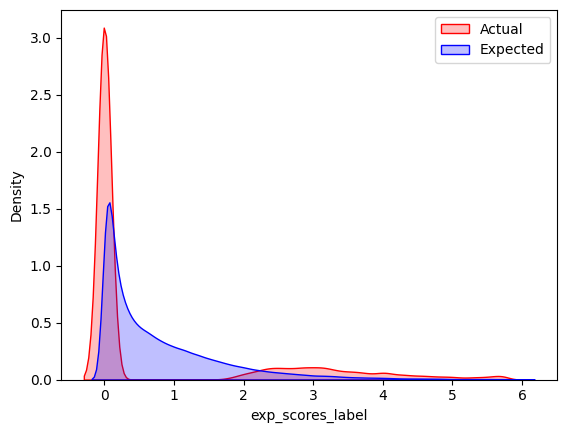

In [47]:
scores_train_evals.plot_distribution()

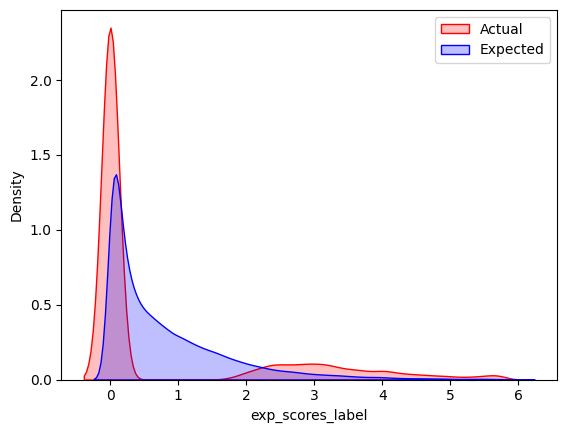

In [48]:
scores_test_evals.plot_distribution()

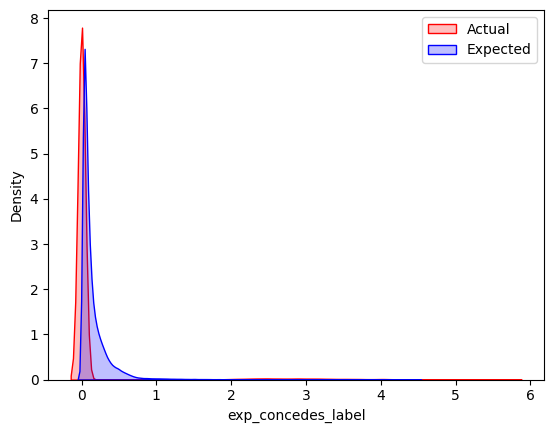

In [49]:
concedes_train_evals.plot_distribution()

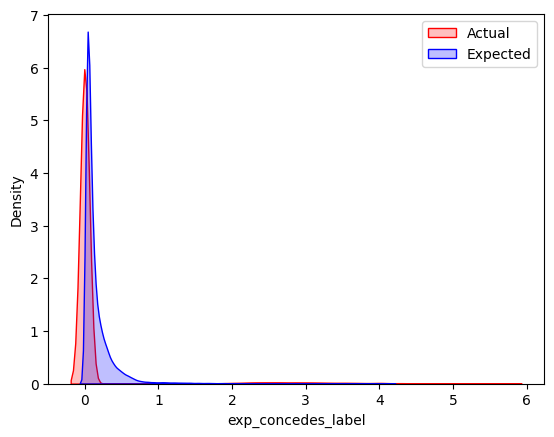

In [50]:
concedes_test_evals.plot_distribution()

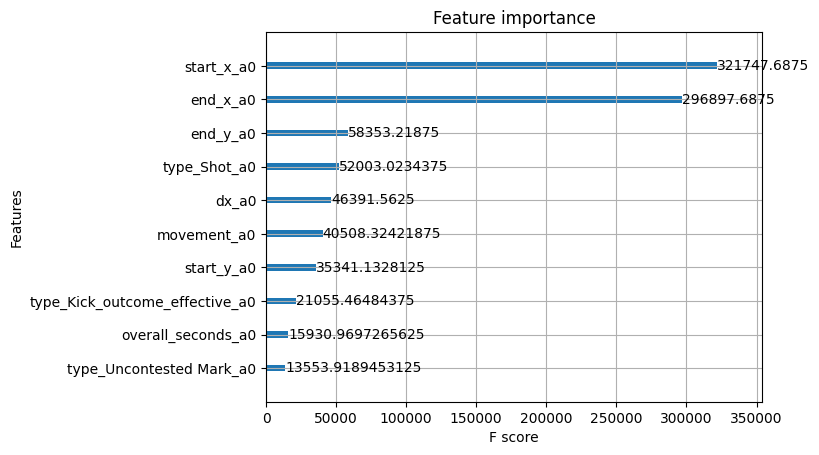

In [51]:
scores_train_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

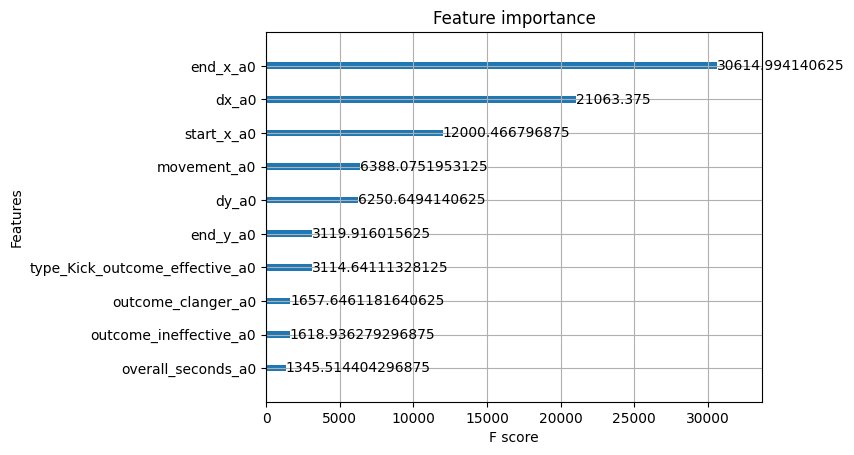

In [62]:
concedes_train_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

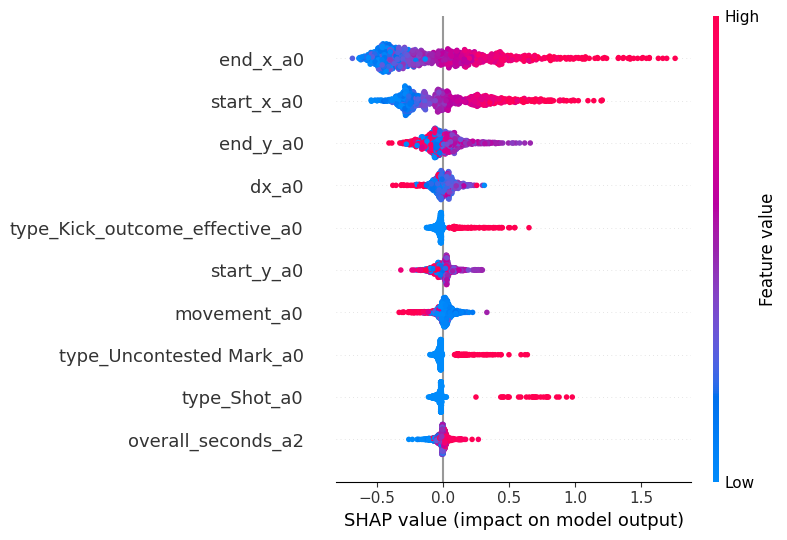

In [52]:
scores_train_evals.plot_shap_summary_plot(sample=1000)

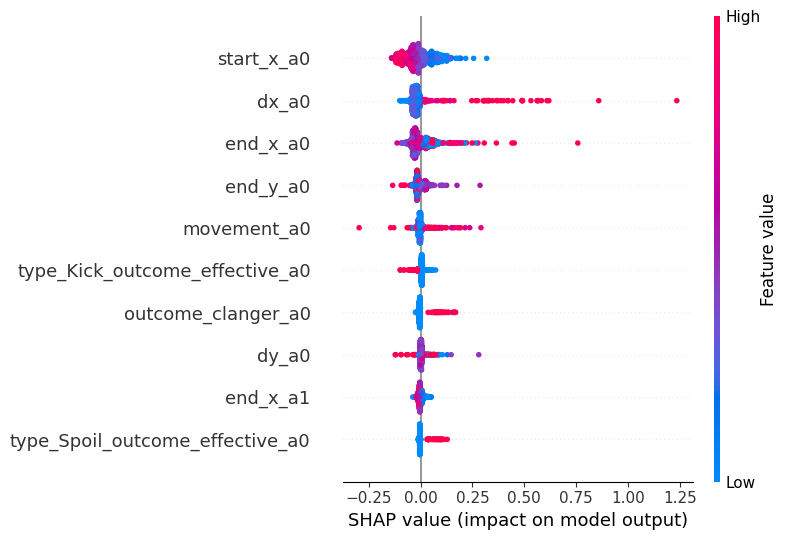

In [63]:
concedes_train_evals.plot_shap_summary_plot(sample=1000)

In [64]:
top_features = scores_test_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['end_x_a0',
 'start_x_a0',
 'end_y_a0',
 'dx_a0',
 'type_Kick_outcome_effective_a0',
 'start_y_a0',
 'movement_a0',
 'type_Shot_a0',
 'type_Uncontested Mark_a0',
 'overall_seconds_a2']

In [ ]:
# for col in top_10_features:
#     scores_test_evals.plot_pdp([col])

In [ ]:
# for col in top_10_features:
#     scores_train_evals.plot_ice([col])
#     scores_test_evals.plot_ice([col])

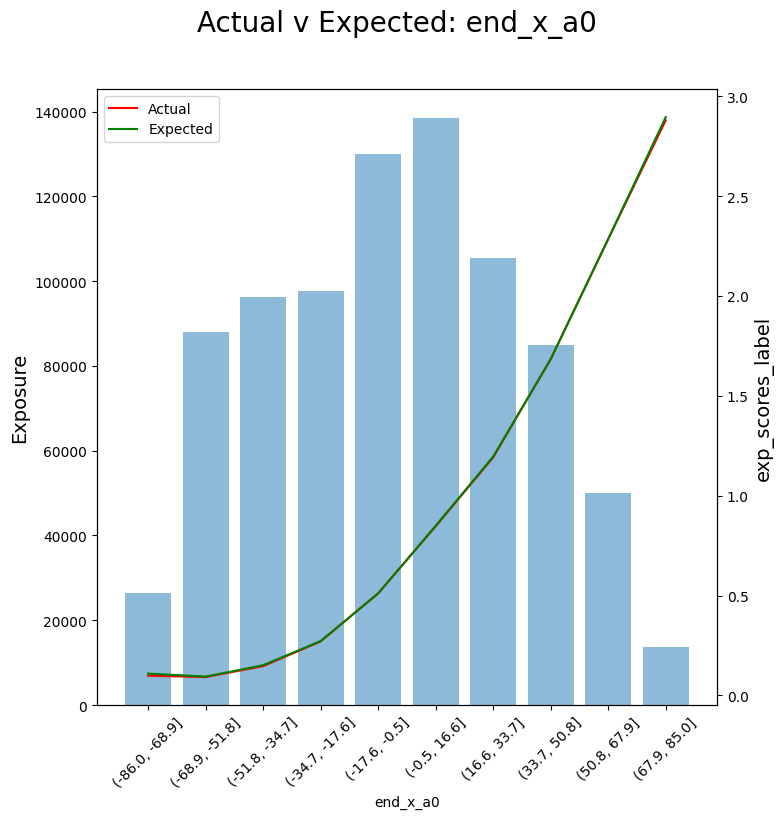

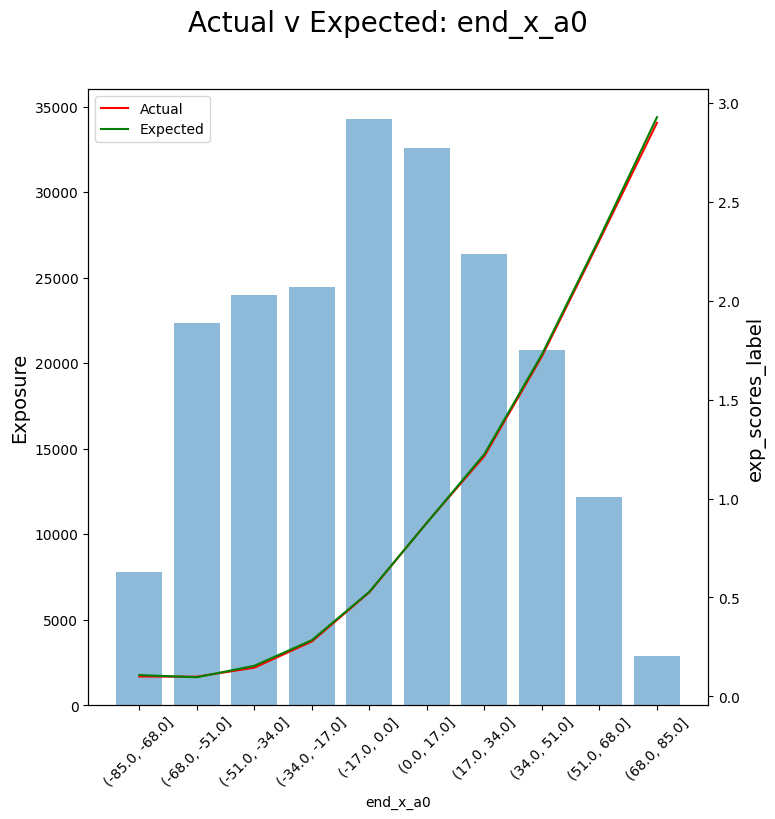

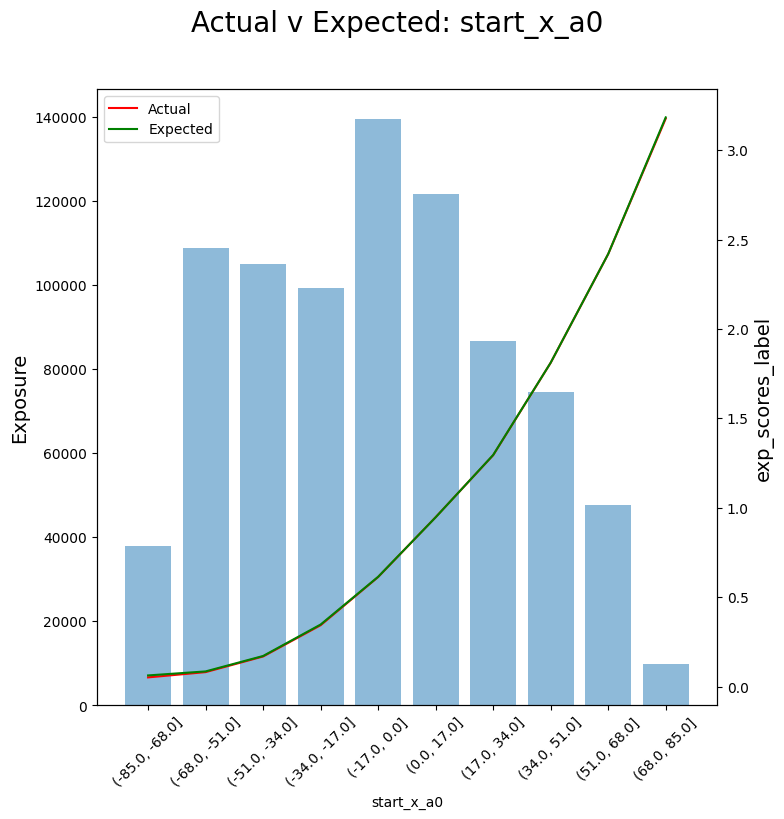

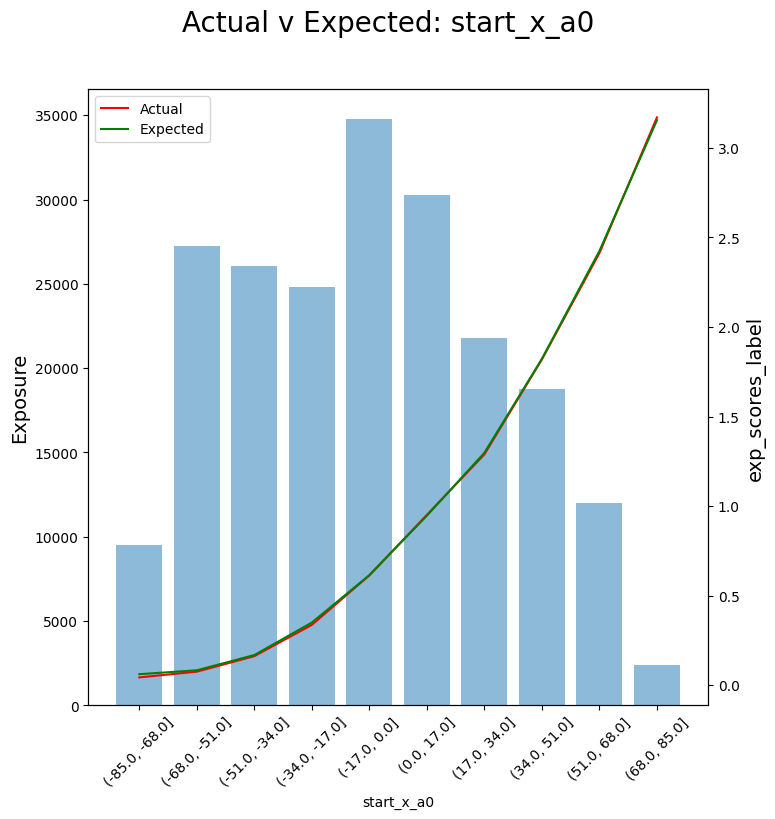

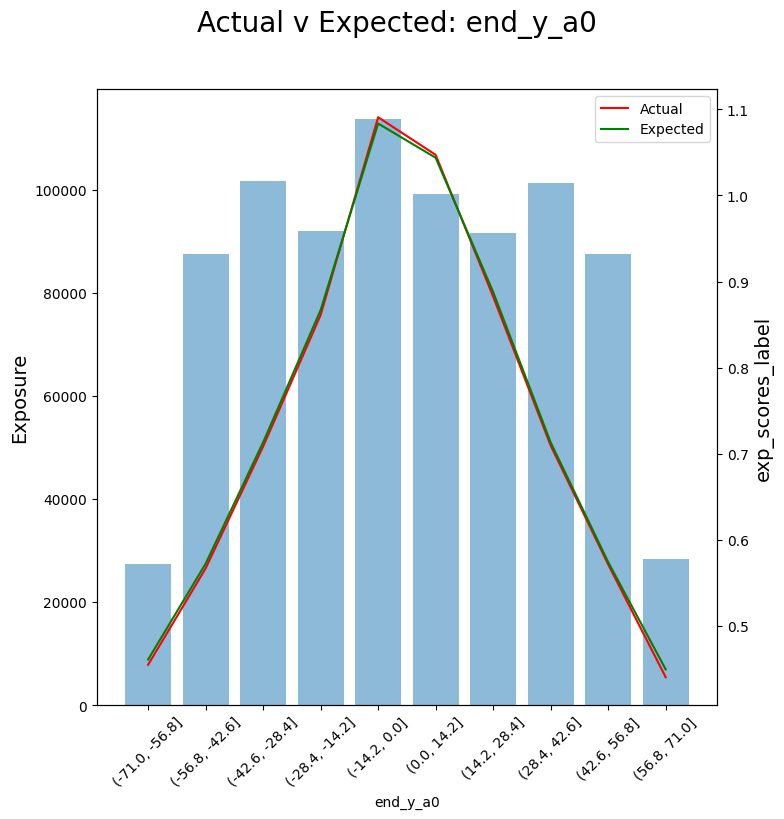

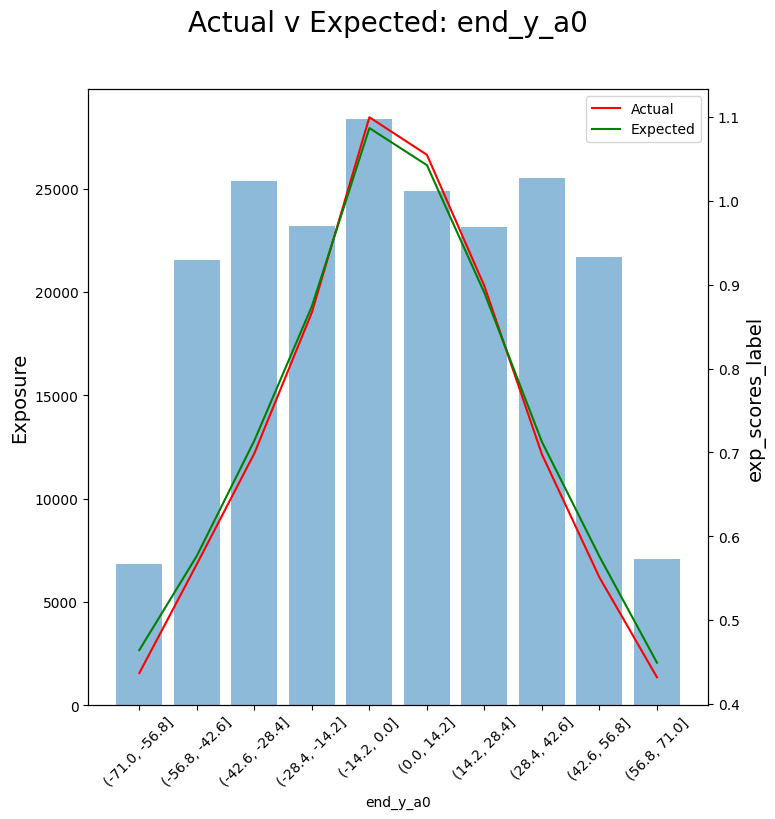

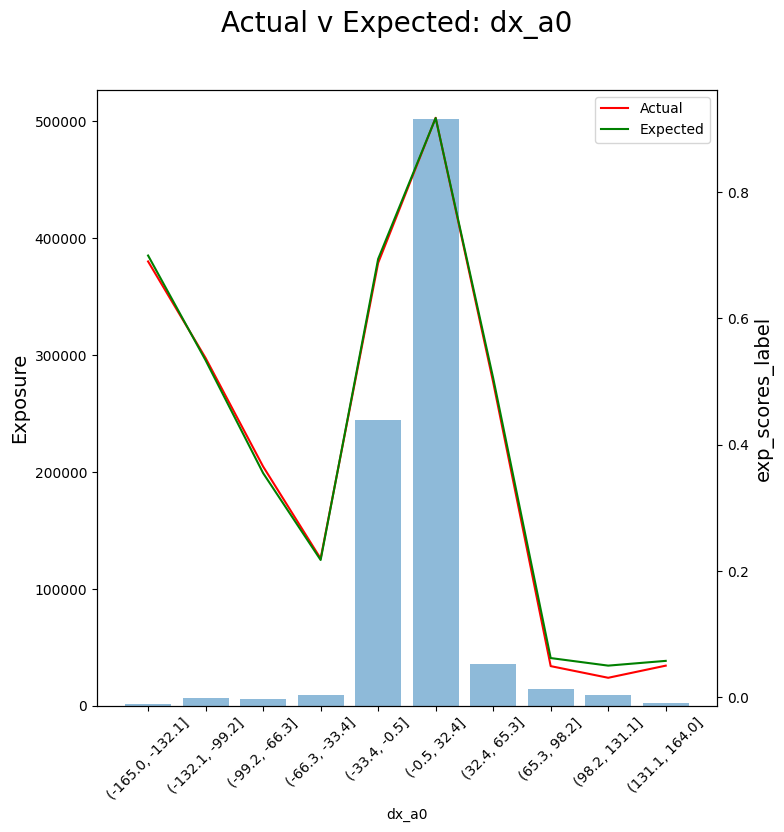

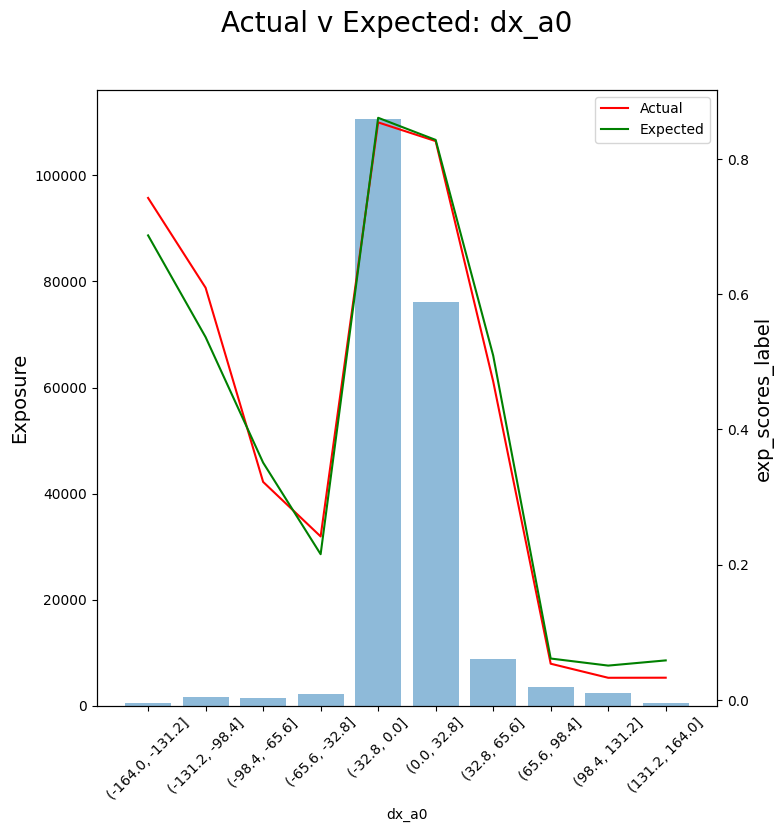

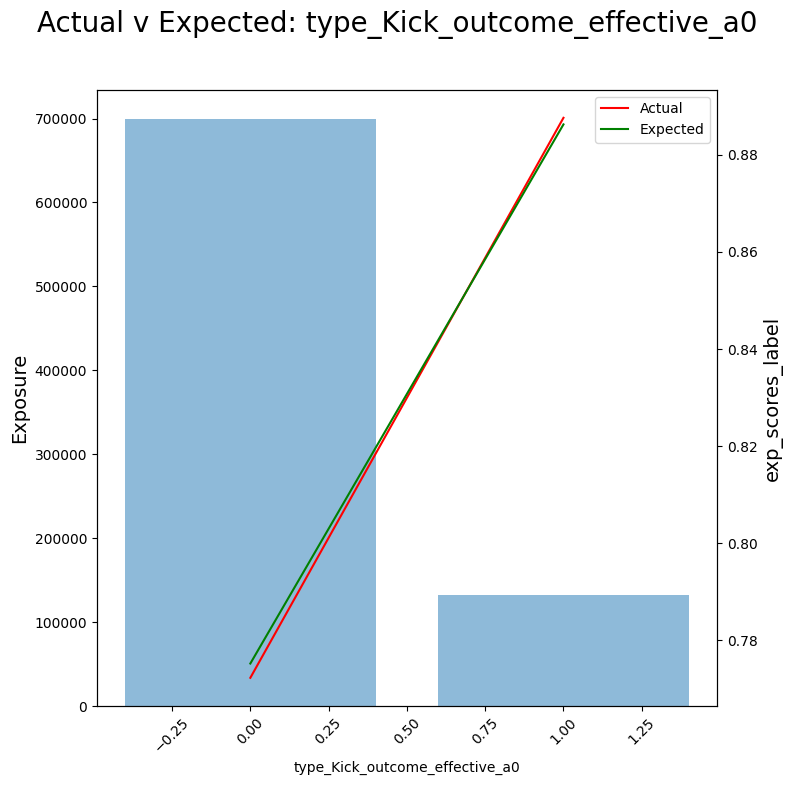

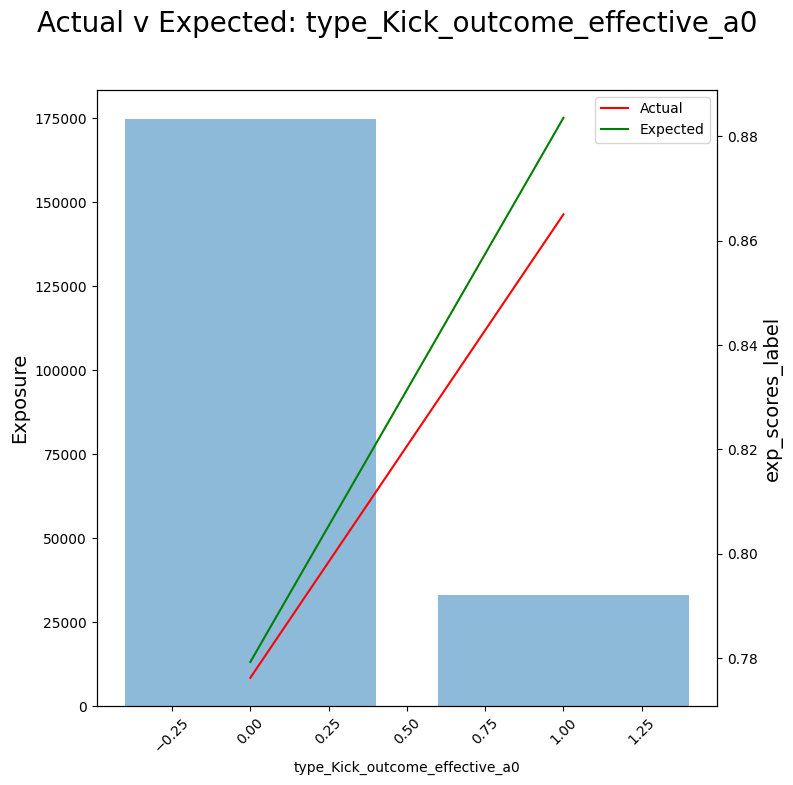

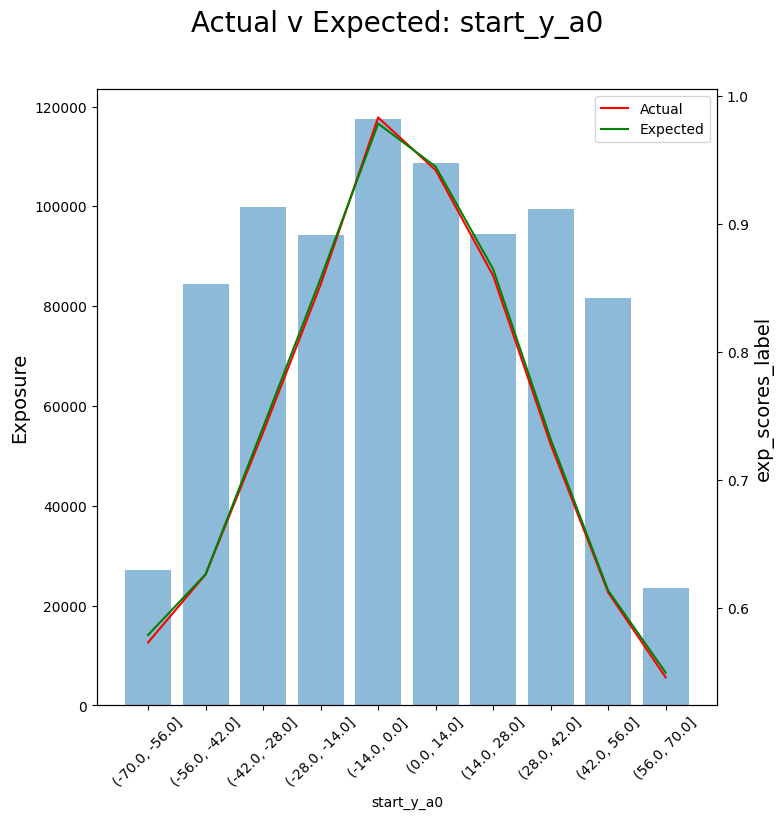

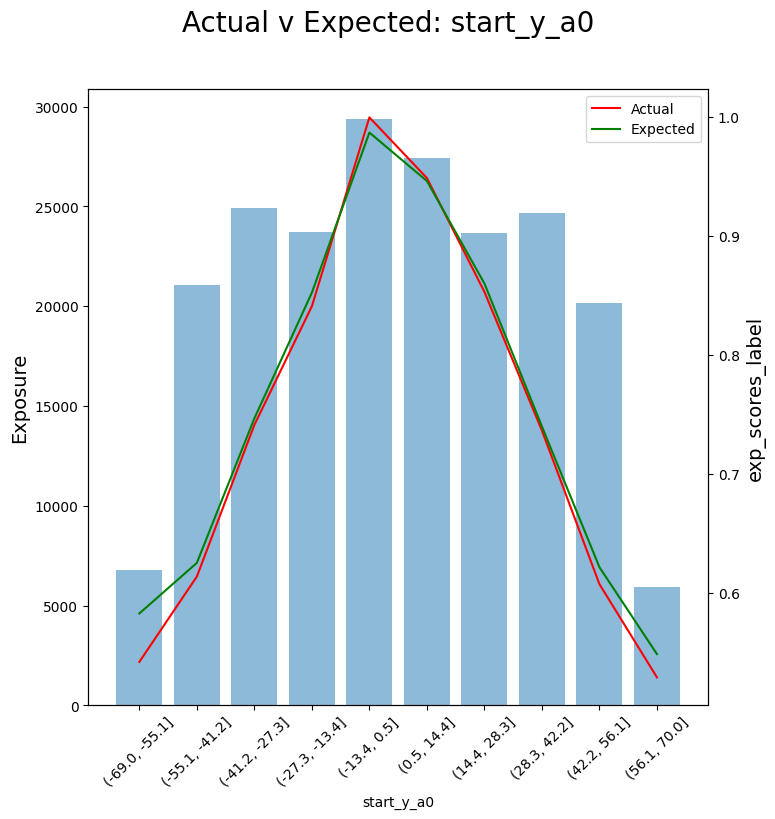

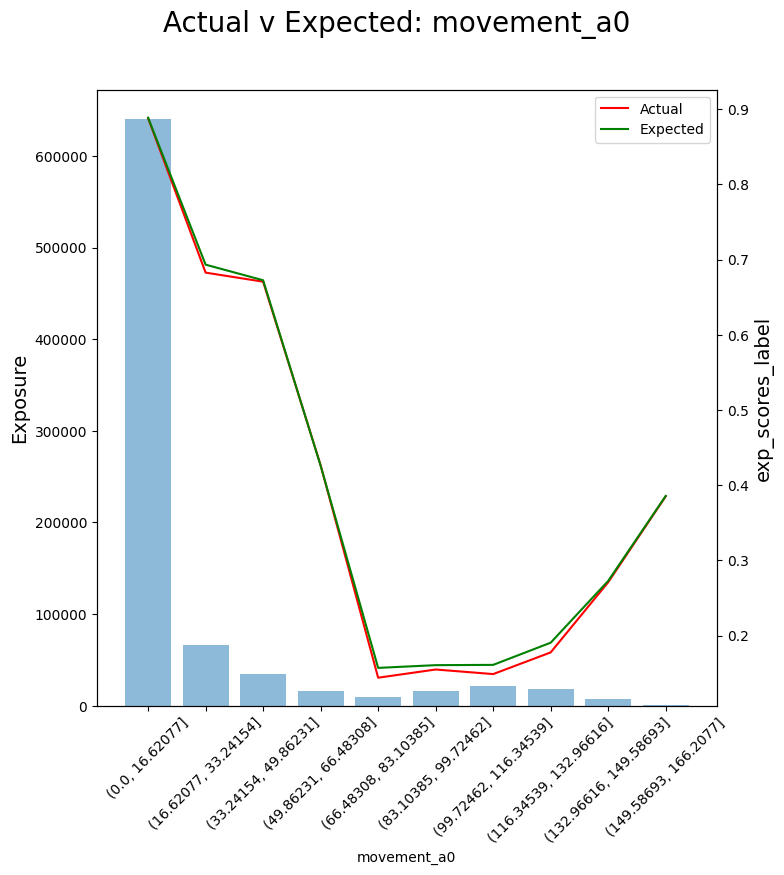

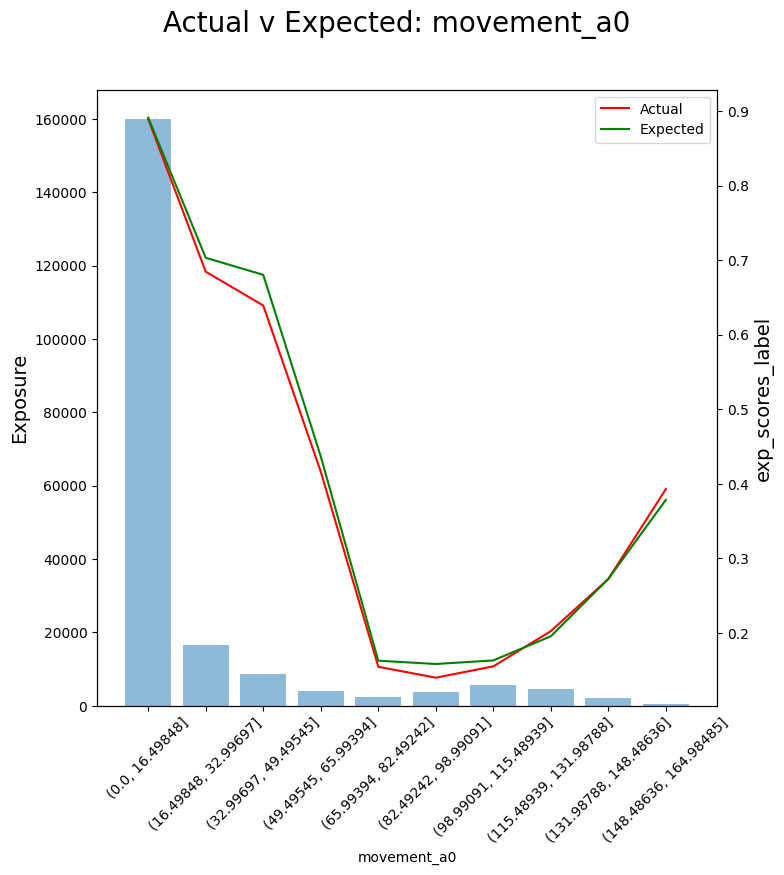

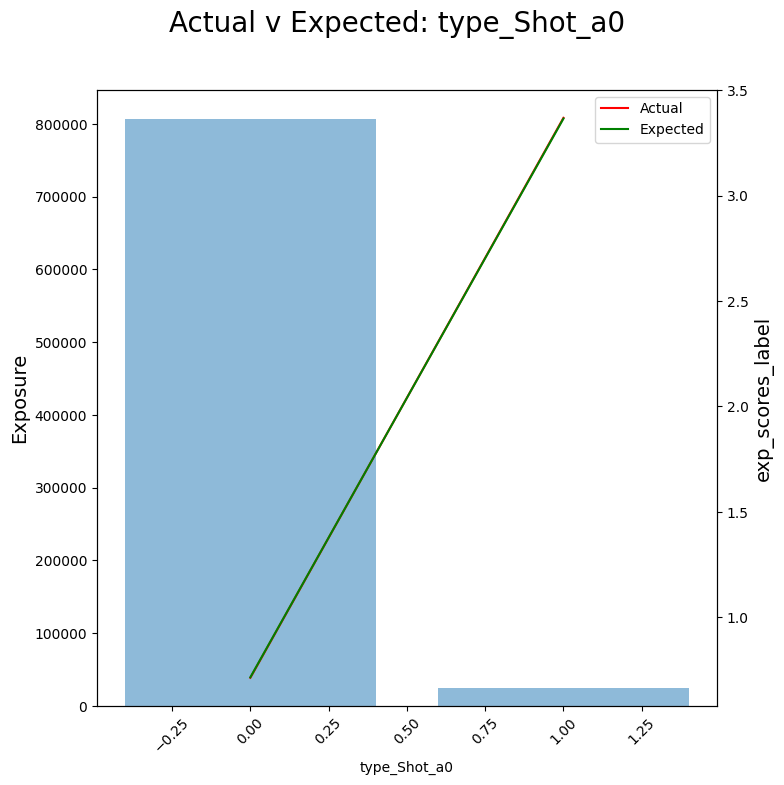

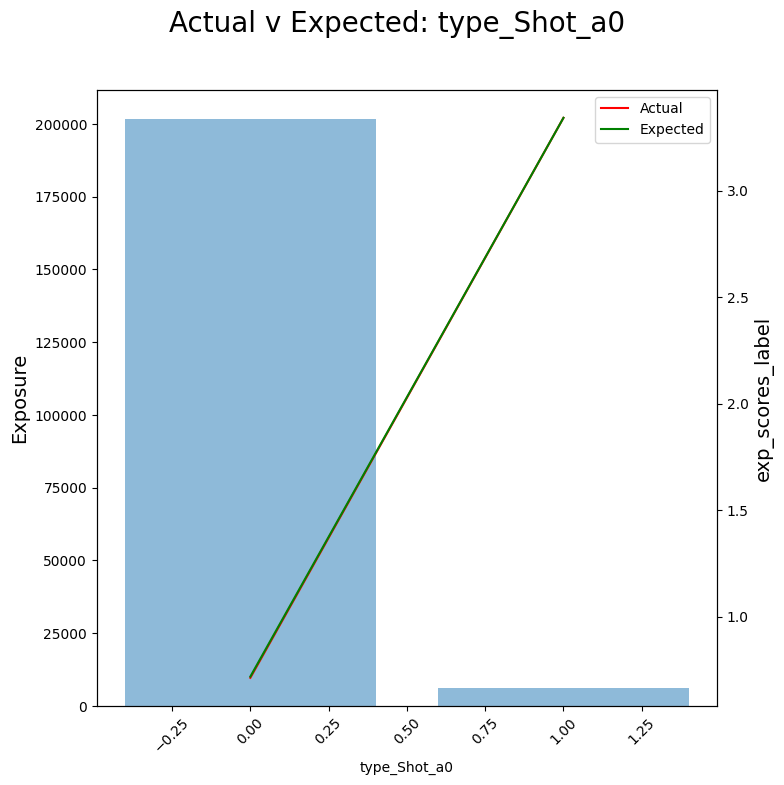

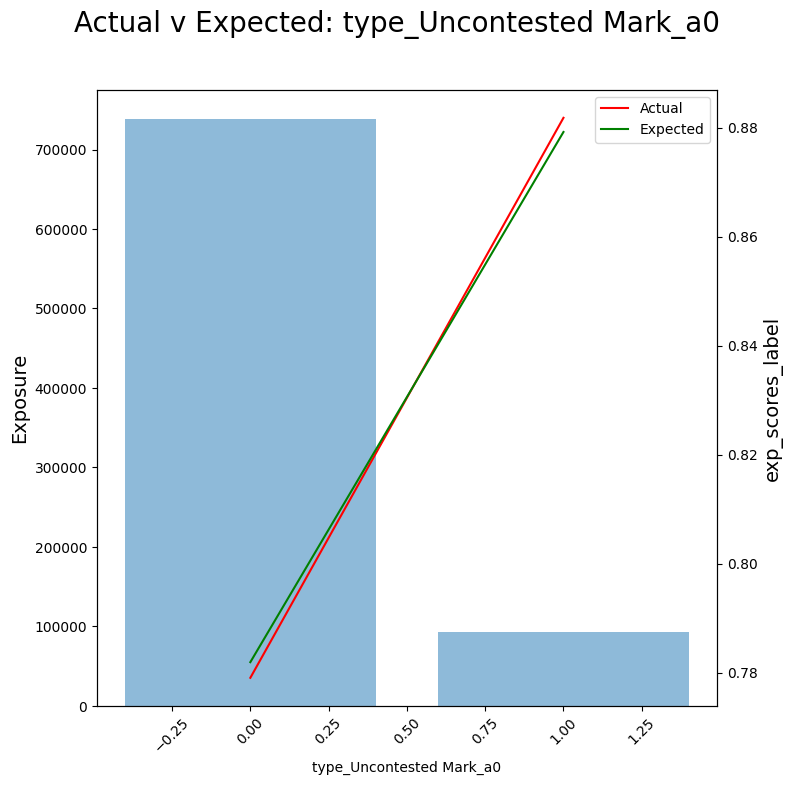

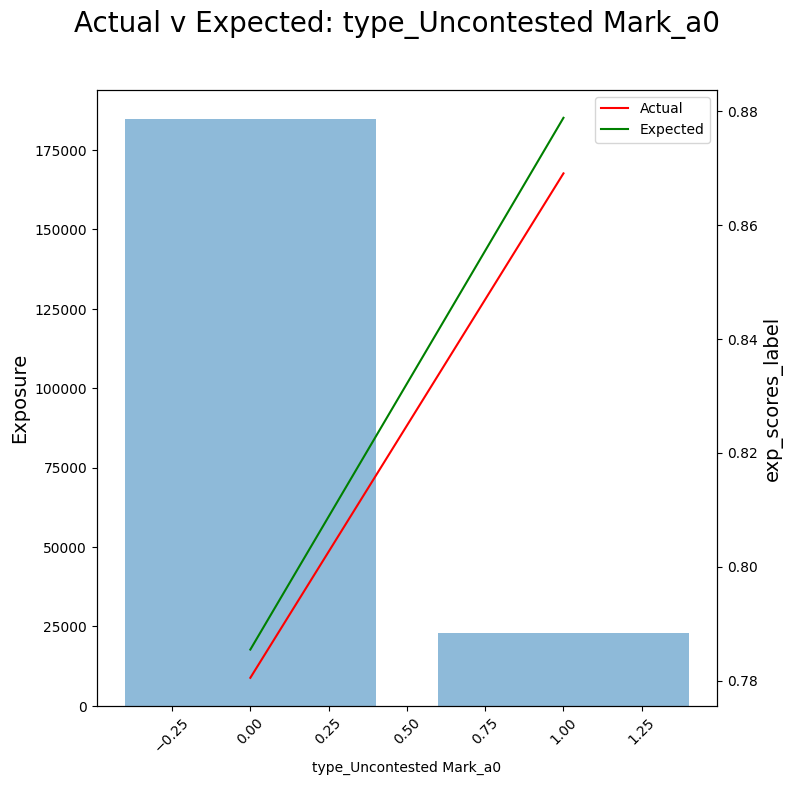

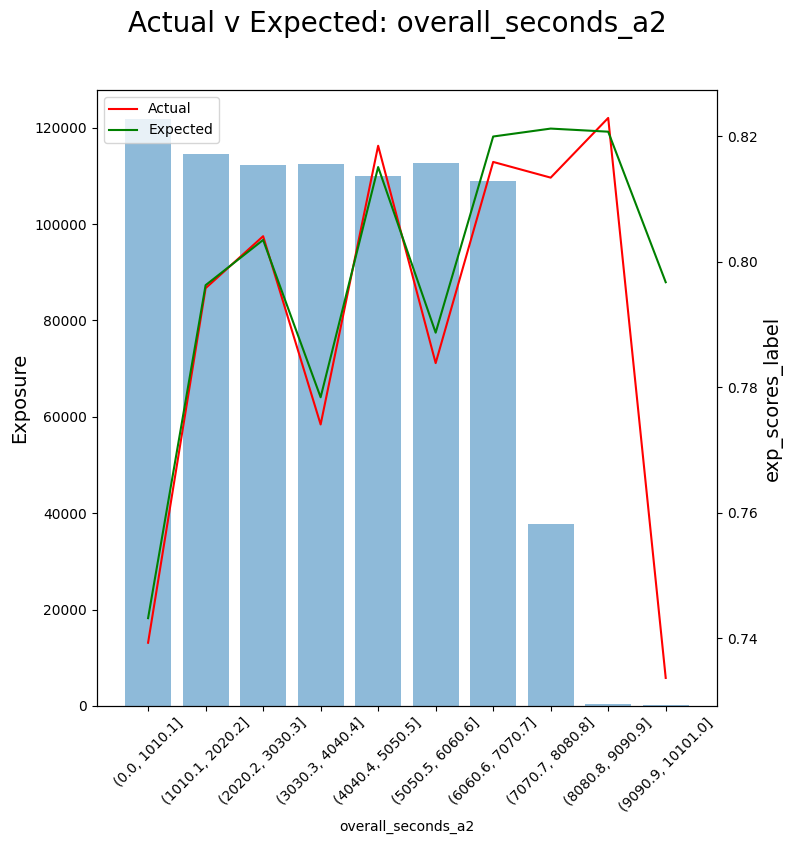

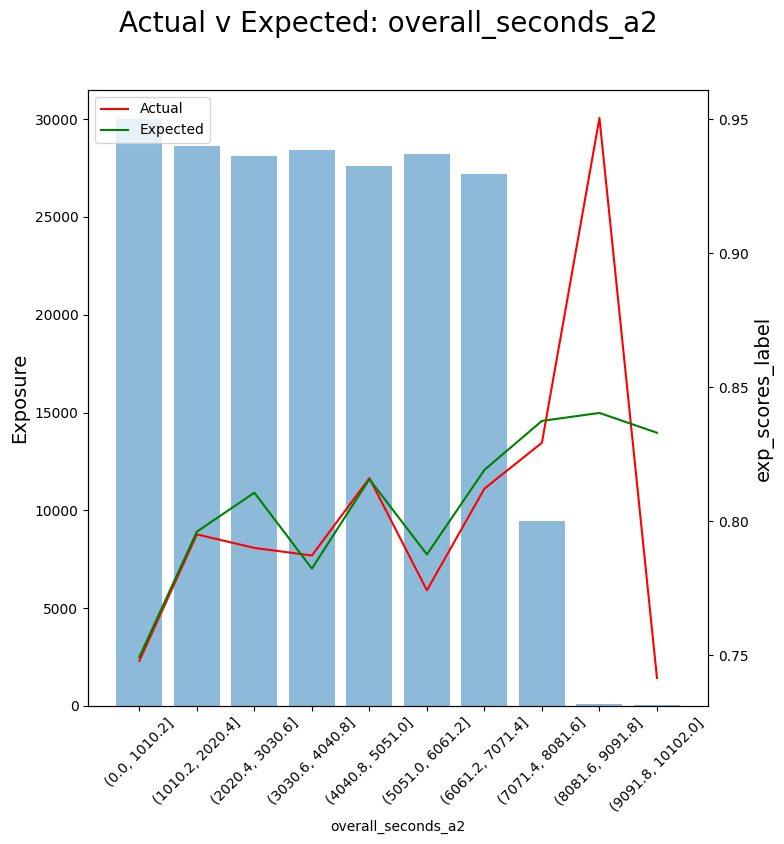

In [55]:
for col in top_10_features:
    scores_train_evals.plot_feature_ave(col)
    scores_test_evals.plot_feature_ave(col)

In [65]:
top_features = concedes_test_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['start_x_a0',
 'end_x_a0',
 'dx_a0',
 'end_y_a0',
 'movement_a0',
 'type_Kick_outcome_effective_a0',
 'outcome_clanger_a0',
 'dy_a0',
 'end_x_a1',
 'type_Spoil_outcome_effective_a0']

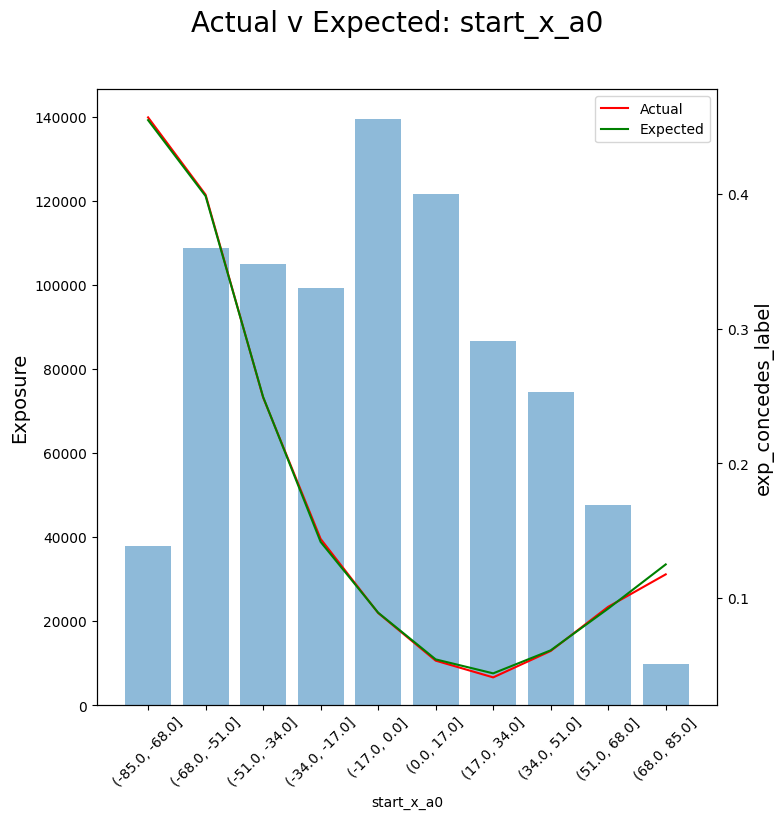

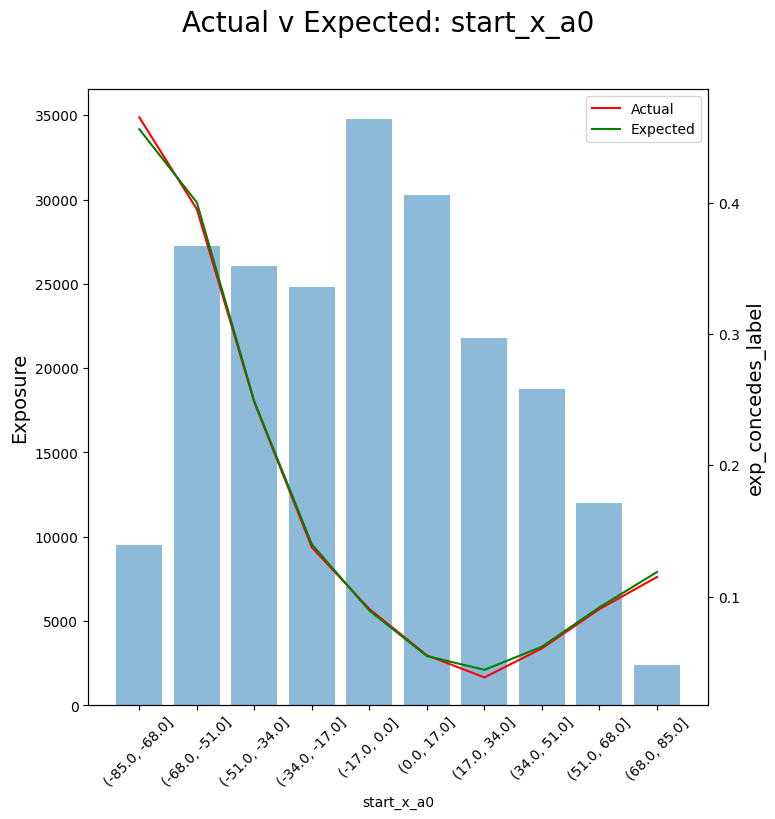

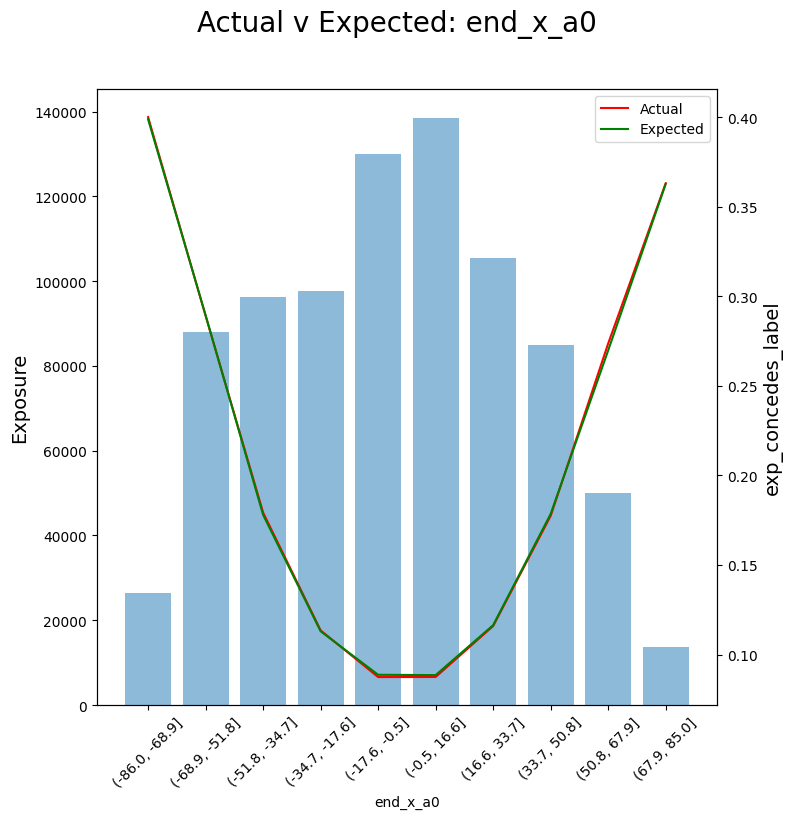

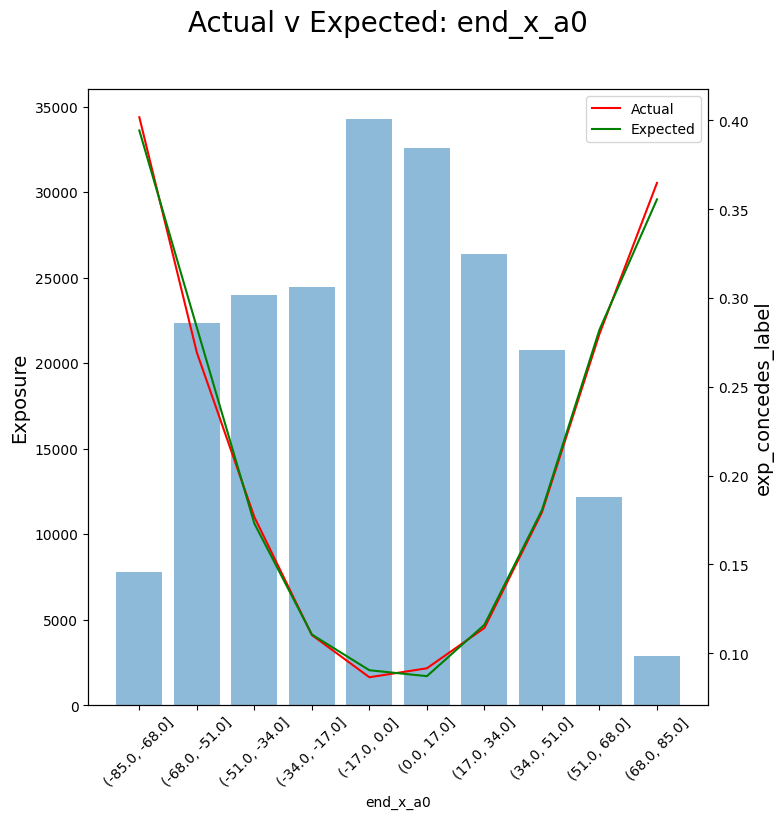

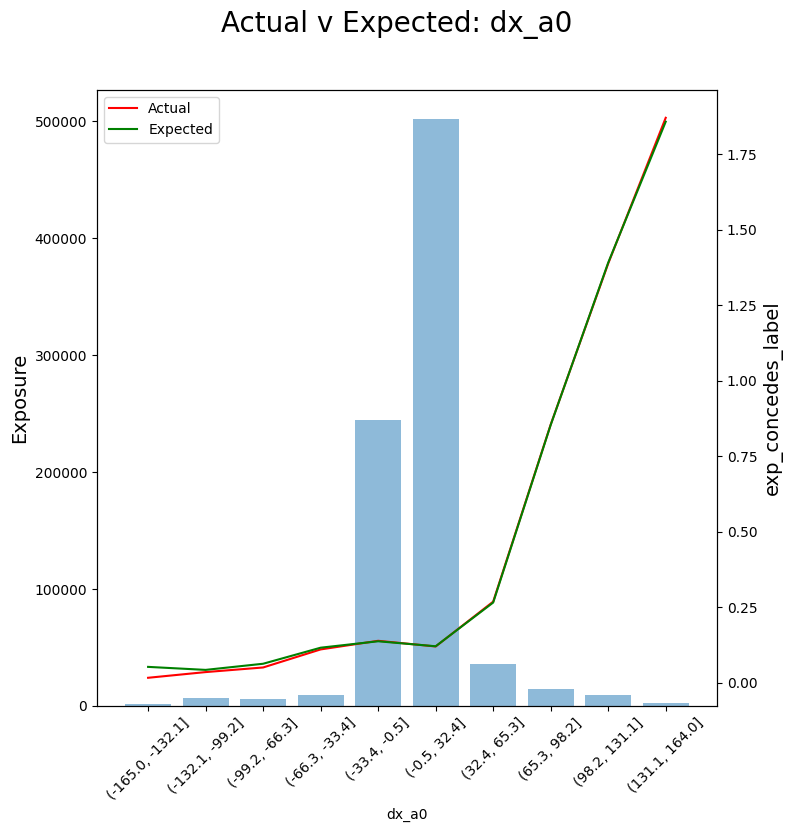

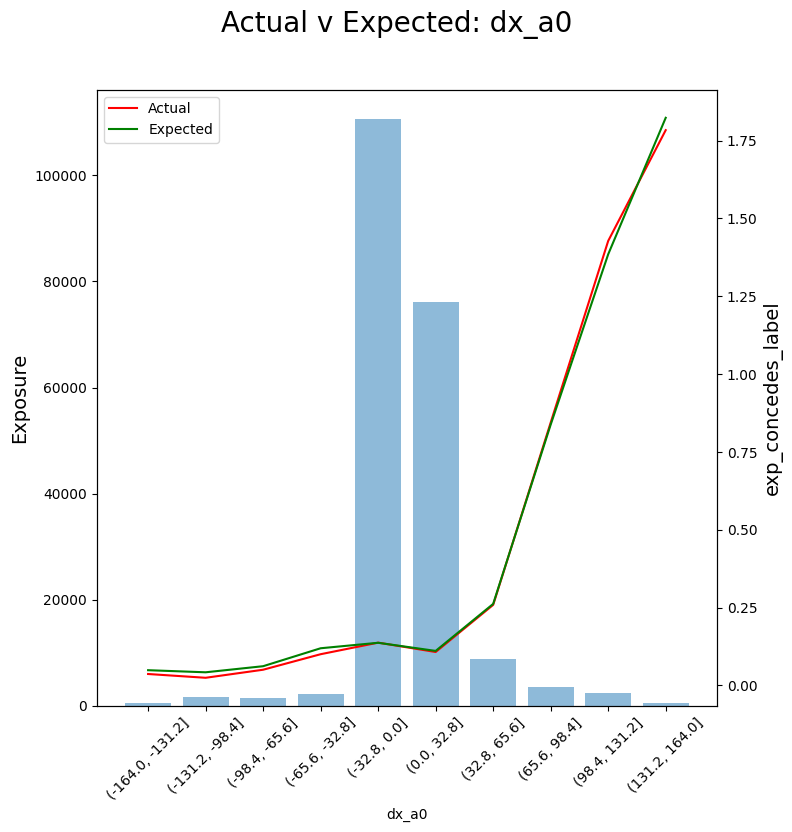

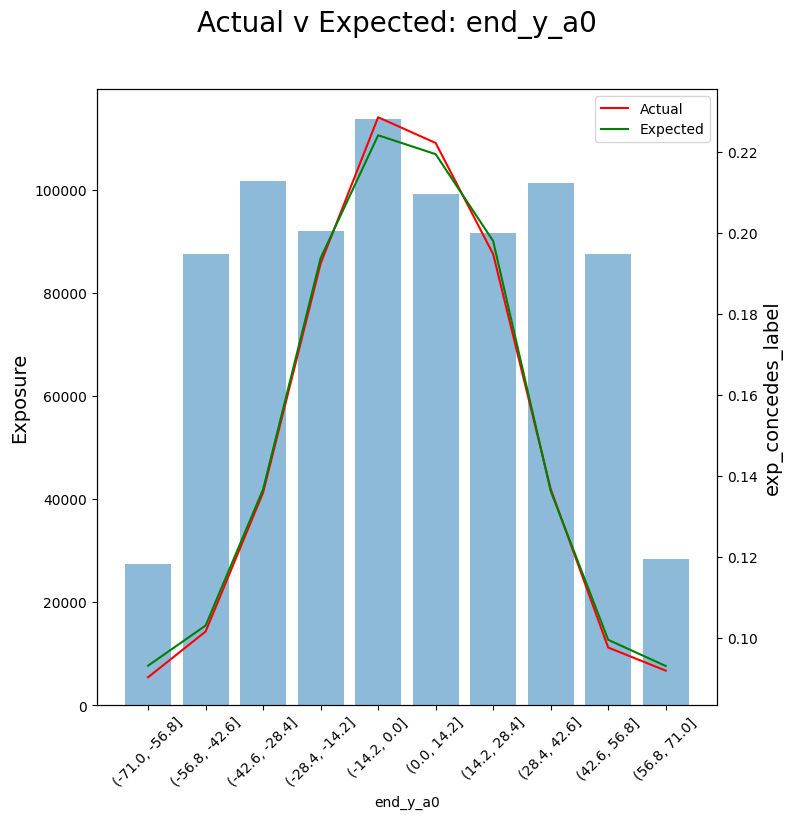

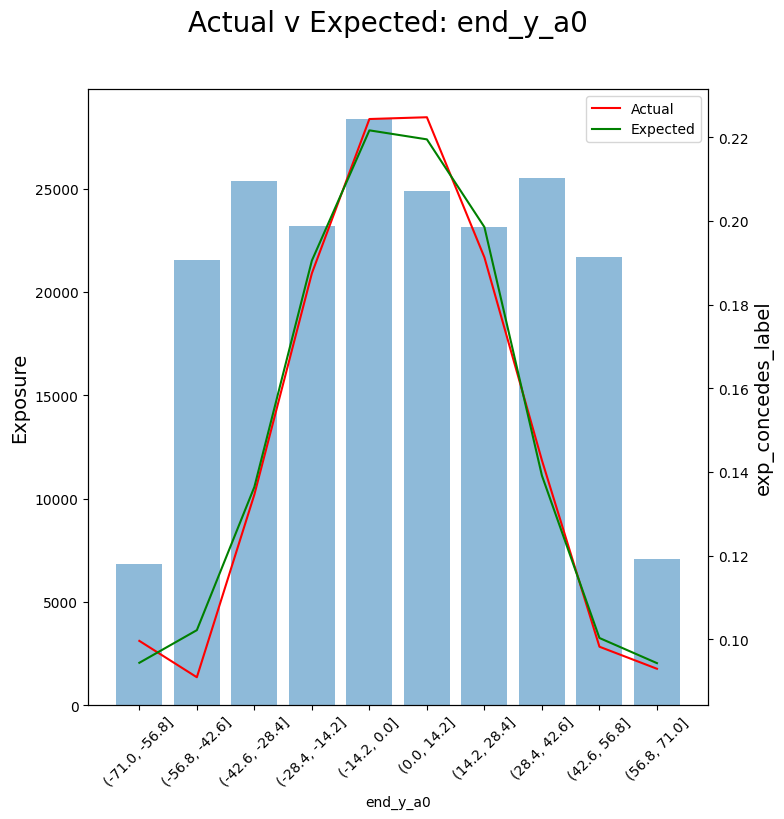

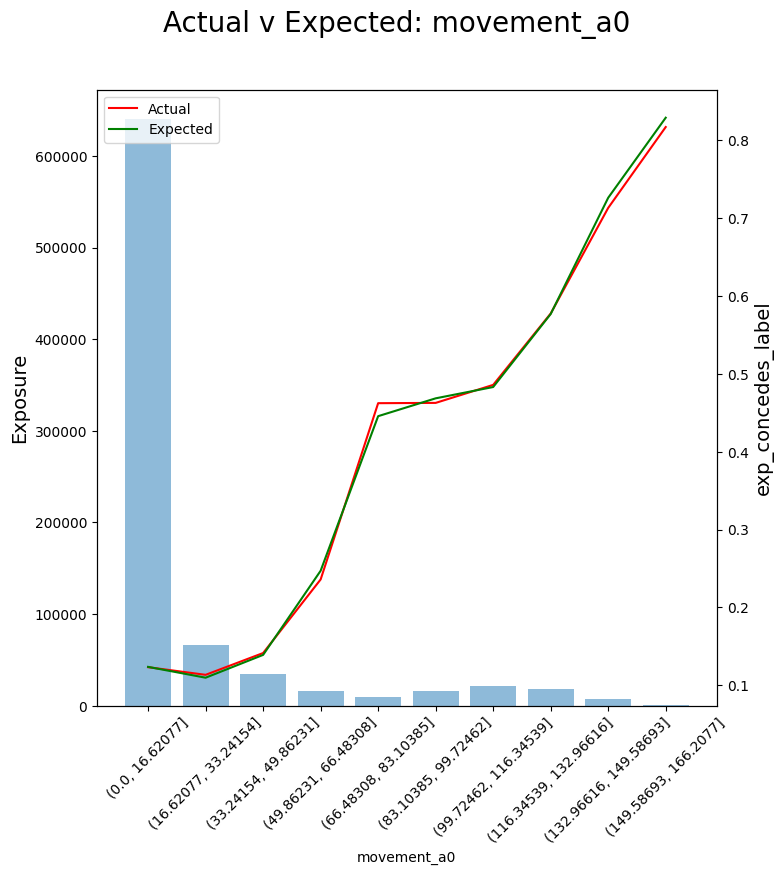

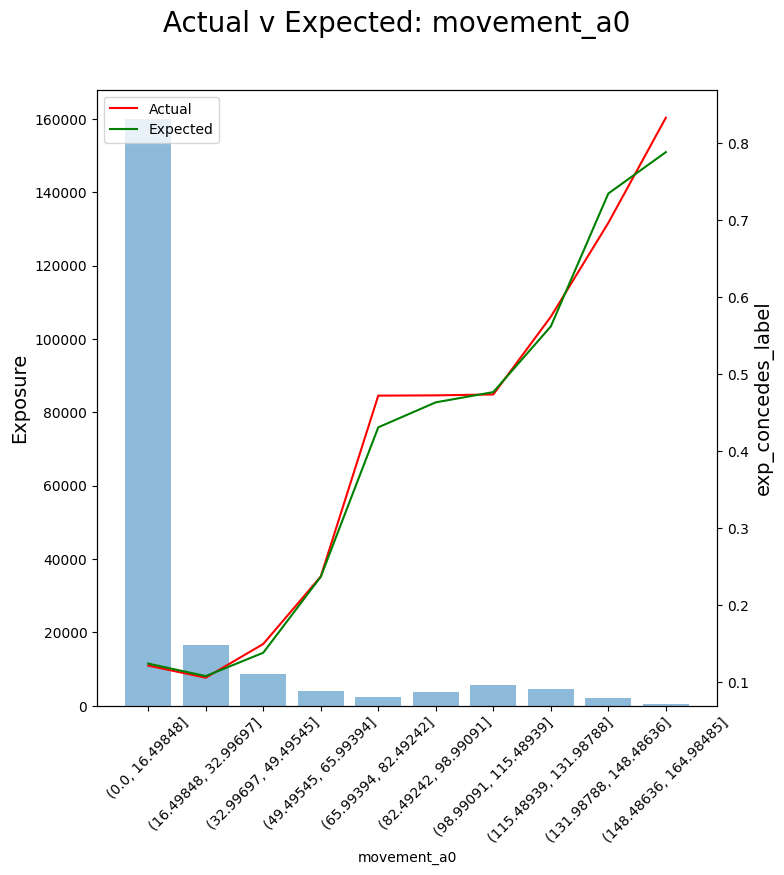

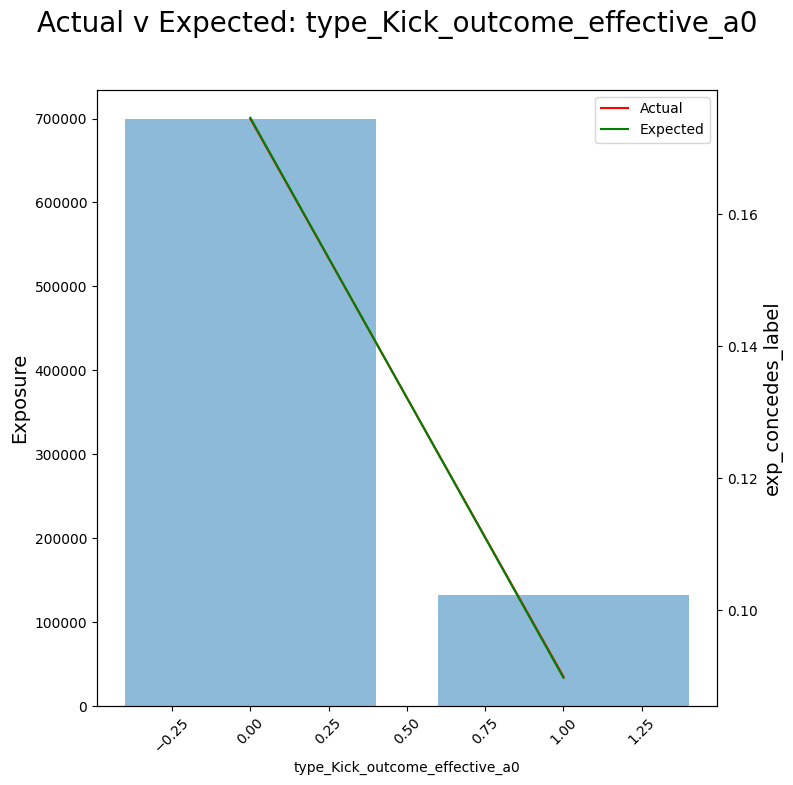

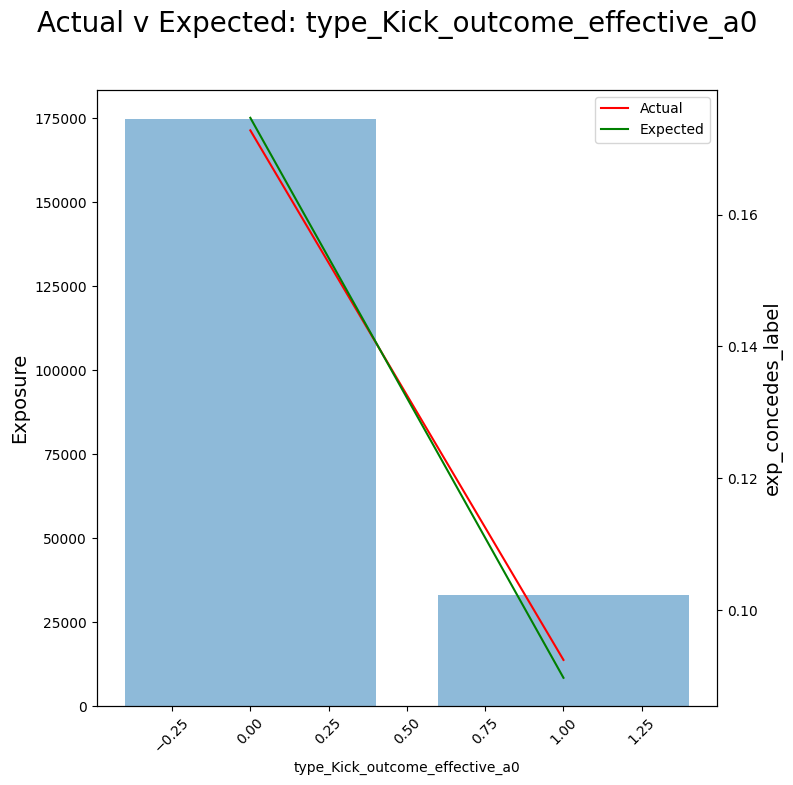

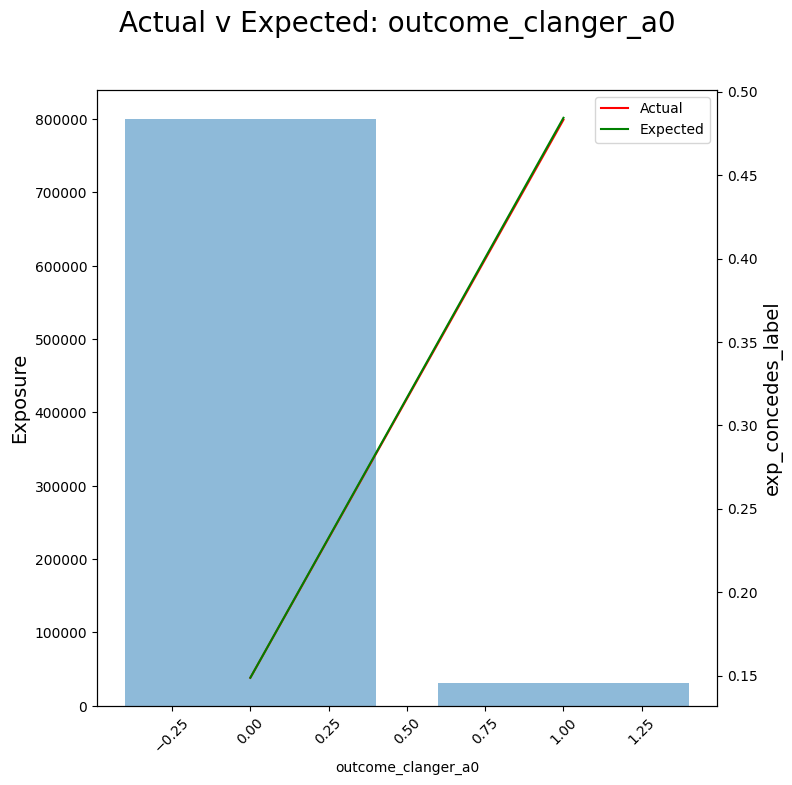

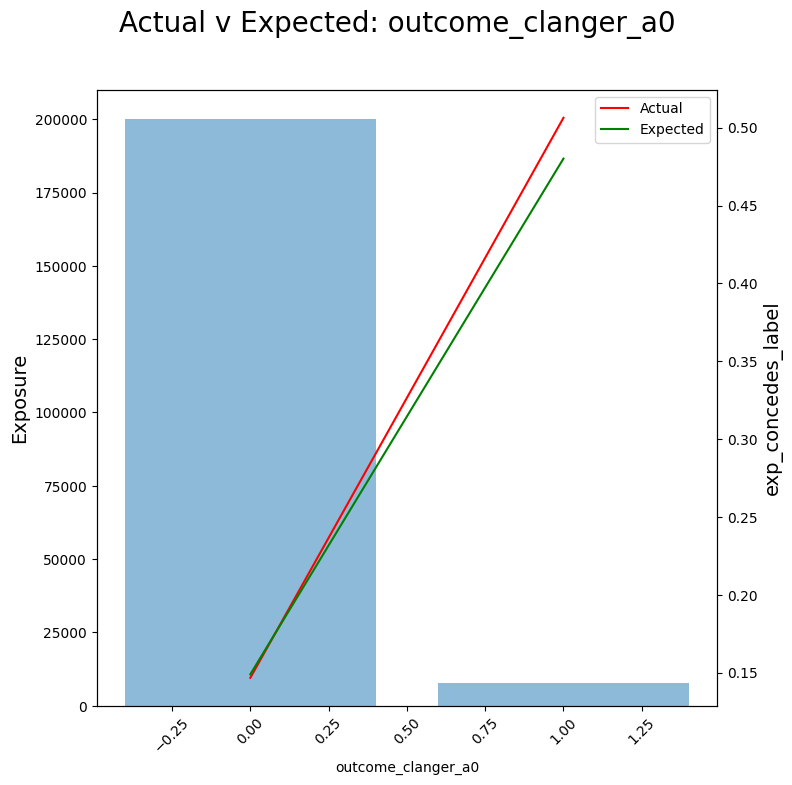

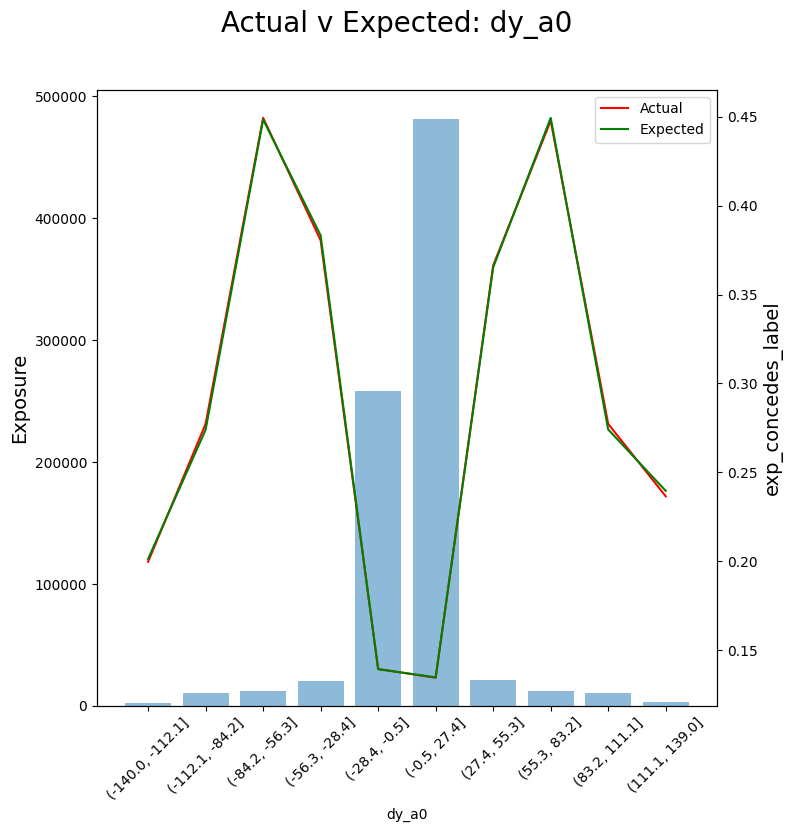

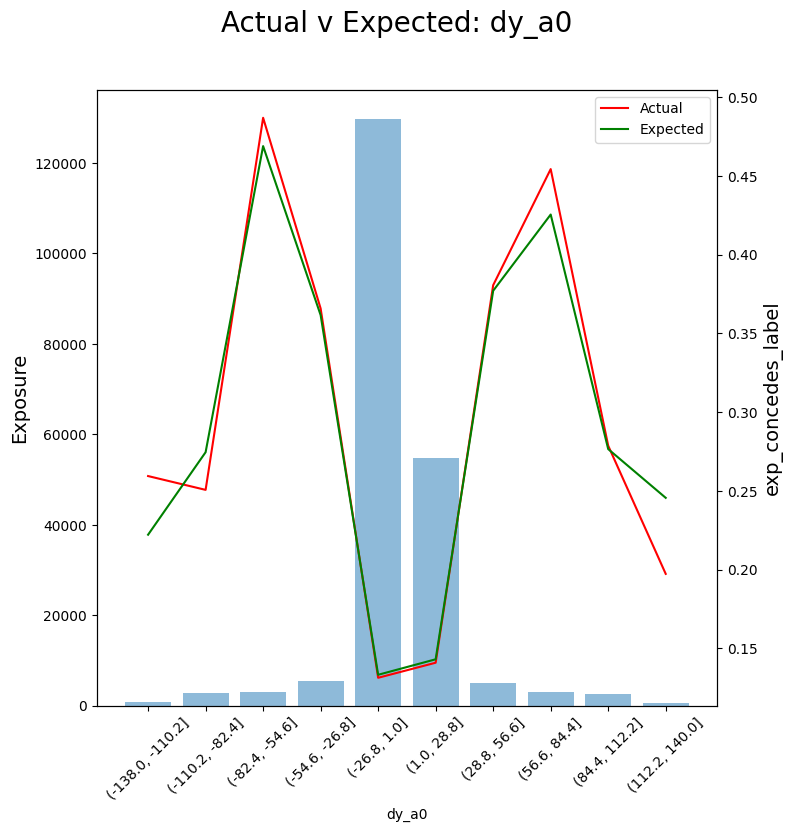

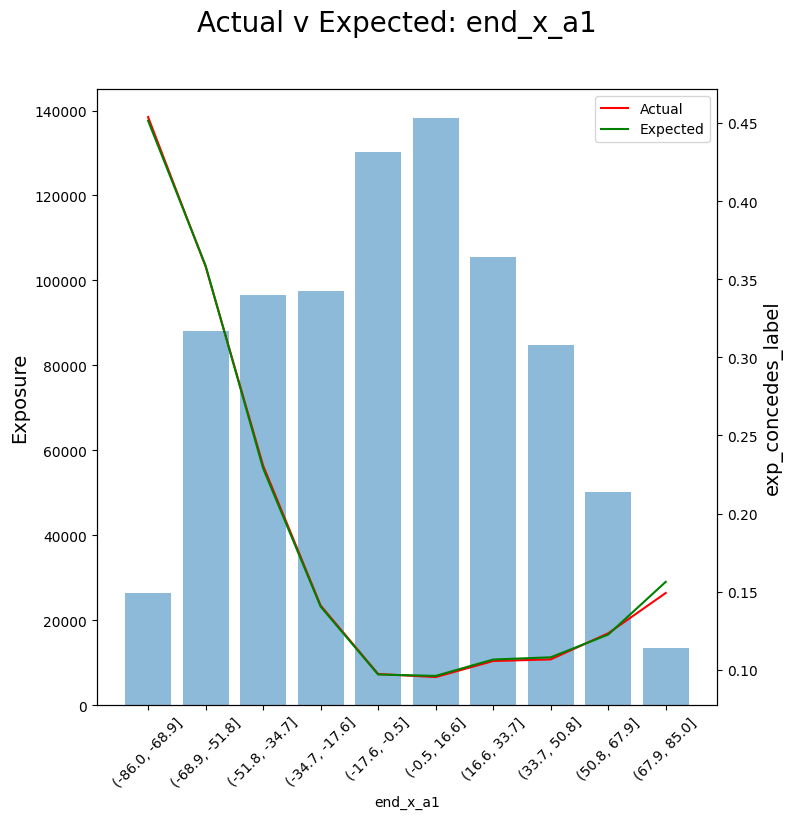

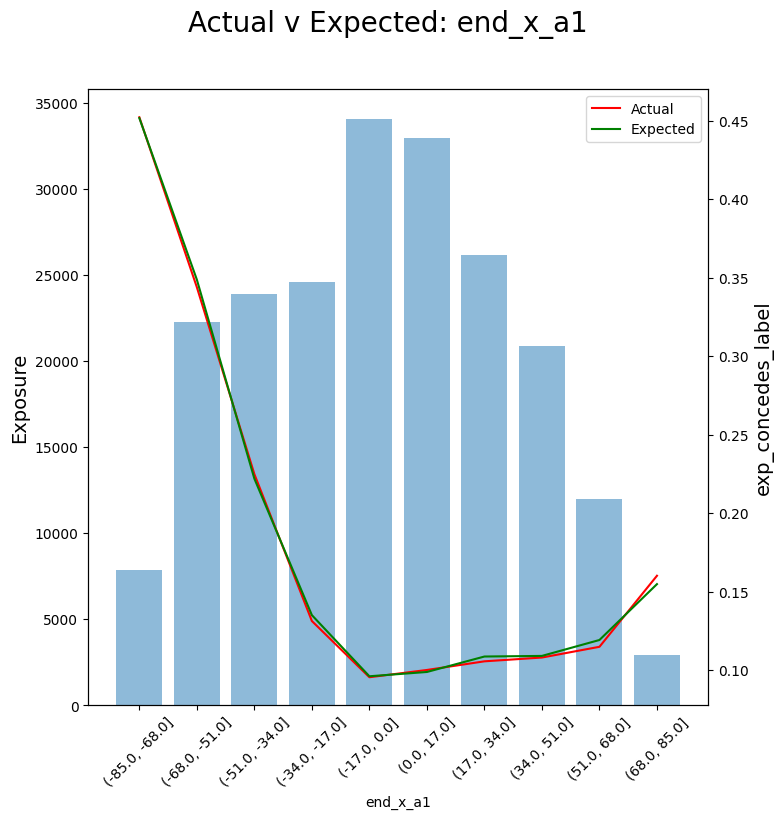

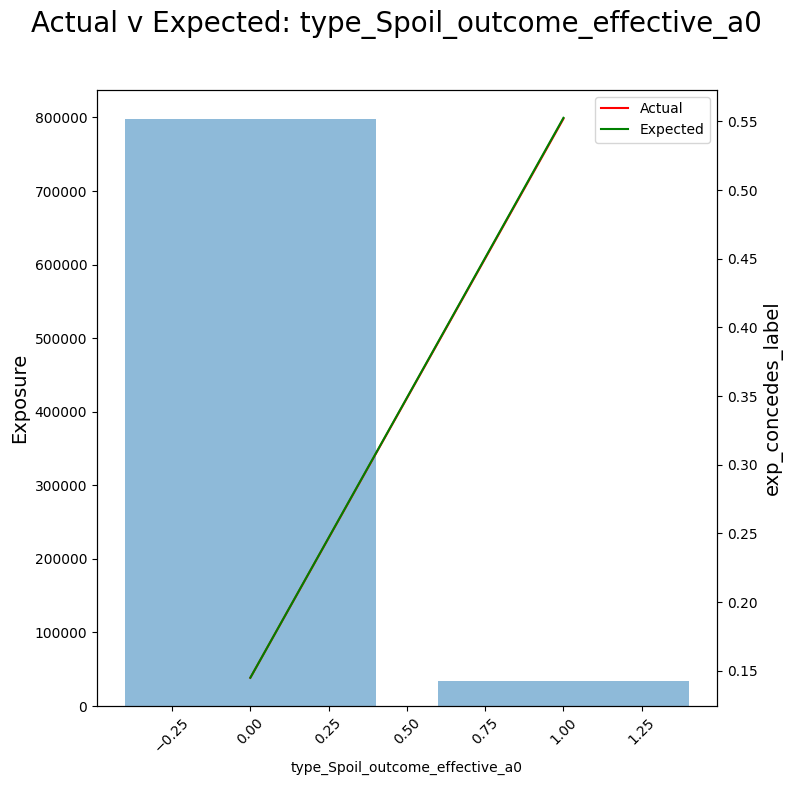

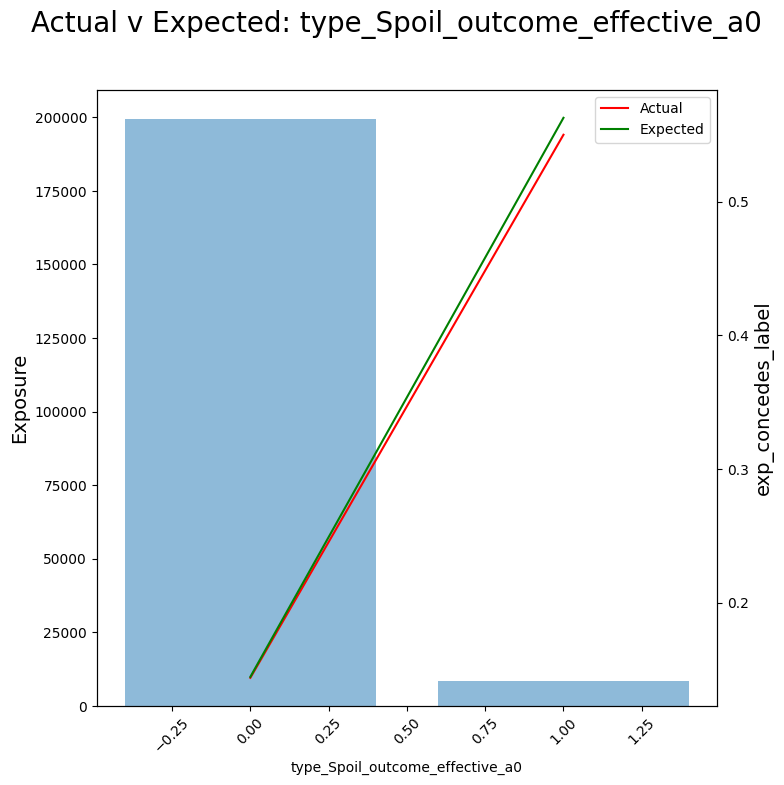

In [66]:
for col in top_10_features:
    concedes_train_evals.plot_feature_ave(col)
    concedes_test_evals.plot_feature_ave(col)

Model Metrics

In [56]:
scores_train_evals.get_mae(), scores_test_evals.get_mae()

(0.7317490814519744, 0.7566967575015763)

In [57]:
scores_train_evals.get_mse(), scores_test_evals.get_mse() 

(1.322549910884768, 1.4121886484435828)

In [58]:
scores_train_evals.get_r2_score(), scores_test_evals.get_r2_score() 

(0.4131034686976318, 0.37275234958965286)

In [59]:
concedes_train_evals.get_mae(), concedes_test_evals.get_mae()

(0.2633054281837874, 0.26431097254663966)

In [60]:
concedes_train_evals.get_mse(), concedes_test_evals.get_mse() 

(0.4649666962978114, 0.46873498034589584)

In [61]:
concedes_train_evals.get_r2_score(), concedes_test_evals.get_r2_score() 

(0.14082658230317713, 0.12628790308030002)